In [1]:
import sys
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/env/lib/python3.7/site-packages')
sys.path.append('/pl/active/banich/studies/Relevantstudies/abcd/data/clustering/analysis/')
from functions import *

from glob import glob

In [2]:
import pandas as pd
from scipy.stats import pearsonr

def get_cors(data, col, columns):
    cors=[]
    for i in columns:

        corr_coef, p_value = pearsonr(data[col],  data[i])
        cor_out =  pd.DataFrame([corr_coef, p_value]).T.assign(region = str(i))
        cor_out.columns = ['cor', 'p', 'region']

        cors.append(cor_out)

    all_cors = pd.concat(cors)
    
    return all_cors

def lin_mod(data, col, columns):
    metrics_all=[]
    for i in columns:
        x = np.array(data[i])
        y = np.array(data[col])
        # add a constant term to the x variable to fit the intercept
        X = sm.add_constant(x)
        # fit the linear regression model
        model = sm.OLS(y, X).fit()
        # extract the p-values and t-values for each coefficient
        p_values = model.pvalues[1]
        t_values = model.tvalues[1]
        metrics = pd.DataFrame([t_values, p_values]).T.assign(var=i)
        metrics.columns = ['t', 'p', 'var']
        metrics = metrics[['var', 't', 'p']]

        metrics_all.append(metrics)

    sig_p = pd.concat(metrics_all).sort_values('p', ascending=True)[['var', 'p']]
    
    return sig_p

In [3]:
sub_new_dist = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/subj_net_distances.csv')

In [4]:
leiden_networks = (pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/leiden_network_glasser_regions.csv')
                   .iloc[:, :2])

leiden_networks.columns = ['parcel', 'network']   

vn_parcels = leiden_networks.query('network == "Visual Network"').parcel.to_list()
smn_parcels = leiden_networks.query('network == "Somatomotor Network"').parcel.to_list()
fpcn_parcels = leiden_networks.query('network == "Frontoparietal Network"').parcel.to_list()
dmn_parcels = leiden_networks.query('network == "Default Mode Network"').parcel.to_list()

In [5]:

net_search = (pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/leiden_network_glasser_regions.csv')
                   .iloc[:, 1:4].reset_index())
net_search['index'] = net_search['index'].astype(str)

def find_parcel(parcel):
    #return net_search.query('index.str.contains('+ '"'+ str(parcel) + '"'+')')
    return net_search.query('index == '+'"'+ str(parcel) + '"')

In [6]:
vector_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/leiden/subj_sm/sub*'
vector_sub_idx = sorted(glob(vector_path, recursive = True))
vector_sub_idx  = [s.replace('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/leiden/subj_sm/', '') for s in vector_sub_idx]

len(vector_sub_idx)

55

In [7]:
mat_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/sub*'
mat_sub_idx = sorted(glob(mat_path, recursive = True))
mat_sub_idx = [s.replace('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/', '') for s in mat_sub_idx]
mat_sub_idx = [s.replace('_sm_vector', '') for s in mat_sub_idx]

len(mat_sub_idx)

54

In [8]:
# find values in list1 that are not in list2
result = list(set(vector_sub_idx) - set(mat_sub_idx))
result 

['sub019']

In [8]:
op_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/subj/subj_operation_sub*.mat'

op_sub_idx = sorted(glob(op_path, recursive = True))

op_sub_idx = [s.replace('/pl/active/banich/studies/wmem/fmri/operation_rsa/subj/subj_operation_', '') for s in op_sub_idx]
op_sub_idx = [s.replace('.mat', '') for s in op_sub_idx]
op_sub_idx = [s.replace('-', '') for s in op_sub_idx]

op_mat_sub_ids = pd.concat([pd.DataFrame(op_sub_idx, columns=['ops_sub']),
                            pd.DataFrame(vector_sub_idx, columns=['vector_sub'])],axis=1)

In [9]:
op_mat_sub_ids.shape

(55, 2)

In [10]:
op_mat_sub_ids = op_mat_sub_ids.assign(ops_sub=lambda x: x['ops_sub'].str.replace('sub', '').astype(int),
                      vector_sub=lambda x: x['vector_sub'].str.replace('sub', '').astype(int))

op_mat_sub_ids.columns = ['SubID', 'sub']

In [11]:
op_mat_sub_ids.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/matched_subid.csv', index=False)

In [12]:
sub_paths = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/sub' #sub003_sm_vector
disp_paths = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/predictions/dispersion/'
dist_paths= '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/predictions/distance/'

import glob
sub_files = glob.glob(sub_paths+'*')
disp_files = glob.glob(disp_paths+'*')
dist_files = glob.glob(dist_paths+'*')

In [13]:
z_data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/ClearMem_Z_Average.csv')

rrs_data = z_data[['SubID','RRS_total', 'RRS_depression', 'RRS_brooding', 'RRS_reflection']]

z_data = z_data[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total']].merge(op_mat_sub_ids, on ='SubID')

In [15]:
z_data.shape

(51, 5)

In [14]:
data = pd.read_csv('/pl/active/banich/studies/wmem/fmri/mvpa/utaustin/data/group_mvpa_auc/ClearMem_Z_Average.csv')

data.shape

(56, 12)

In [15]:
id_no_19 = op_mat_sub_ids.query('sub != 19').reset_index()
z_data_no_19 = z_data.query('sub != 19').reset_index()

In [16]:
op_mat_sub_ids.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/rest/rsa_network_subject_ids.csv' ,index=False)

In [17]:
disp_list = []
for filename in disp_files:
    op = (filename.replace('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/predictions/dispersion/', "")
 .replace('_cent_prediction_with_disp.csv', ""))
 
    disp_df = (pd.read_csv(filename)
               .iloc[:, 1:]
               .reset_index()
               .drop('ID', axis=1)
               #.assign(op = op)
              )
    
    disp_df = pd.merge(z_data_no_19, disp_df, on='index').drop(['index', 'sub', 'z_ave', 'PSWQ_total', 'WBSI_total'], axis=1).dropna()
    
    new_column_names = {col: op+'_disp_'+ str(col) for col in  disp_df.iloc[:, 1:].columns}
    disp_df = disp_df.rename(columns=new_column_names)
    
    #disp_df = pd.merge(sub_ids, disp_df, on = 'index').drop('index', axis=1)
    #disp_df = pd.merge(z_data, disp_df, on = 'SubID')
    disp_list.append(disp_df)
    
op_disp = pd.concat(disp_list, axis=1).drop_duplicates('SubID')
op_disp = op_disp.loc[:,~op_disp.columns.duplicated()]
op_disp = pd.merge(z_data_no_19[['SubID', 'z_ave', 'PSWQ_total', 'WBSI_total']], op_disp,  on='SubID').dropna()

In [20]:
from glob import glob 

g1_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/*_sm_vector/*_sm_vector_g1_all_ops.csv'
g2_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/*_sm_vector/*_sm_vector_g2_all_ops.csv'
g3_path = '/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/subj/*_sm_vector/*_sm_vector_g3_all_ops.csv'

def sub_grads(paths, grad):
    g_dfs=[]
    for i in sorted(sorted(glob(paths, recursive = True))): 
        g_dfs.append((pd.read_csv(i).iloc[:, 2:]))
    sub_g = pd.concat(g_dfs).assign(gradient=grad)
    sub_g['sub'] = sub_g['sub'].str.replace('_sm_vector','').str.replace('sub','').astype(int)
    
    return sub_g

sub_g_list=[]
for i, j in zip([g1_path, g2_path, g3_path], range(1,4)):
    sub_g_list.append(sub_grads(i, j))

sub_gs=pd.concat(sub_g_list)

In [21]:
def new_grad_names(data, name):
    new_column_names = {col: name + str(col) for col in data.columns}
    data = data.rename(columns=new_column_names)
    return data

def long_wide_grads(data, sub, grad):
    s_g_main = data.query('sub =='+str(sub)+' and gradient =='+str(grad))[['maintain']].T
    s_g_replace = data.query('sub =='+str(sub)+' and gradient =='+str(grad))[['replace']].T
    s_g_suppress = data.query('sub =='+str(sub)+' and gradient =='+str(grad))[['suppress']].T
    s_g_clear = data.query('sub =='+str(sub)+' and gradient =='+str(grad))[['clear']].T

    s_g_main = new_grad_names(s_g_main, 'g'+str(grad)+'_main_').reset_index(drop=True)
    s_g_replace = new_grad_names(s_g_replace, 'g'+str(grad)+'_replace_').reset_index(drop=True)
    s_g_suppress = new_grad_names(s_g_suppress, 'g'+str(grad)+'_suppress_').reset_index(drop=True)
    s_g_clear = new_grad_names(s_g_clear, 'g'+str(grad)+'_clear_').reset_index(drop=True)

    wide_g = pd.concat([s_g_main, s_g_replace, s_g_suppress, s_g_clear], axis=1)
    
    return wide_g

all_sub_gs_wide = []
for i in sub_gs['sub'].unique():
    wide_sub_gs = []
    for j in range(1,4):
        wide_sub_gs.append(long_wide_grads(sub_gs, i, j))     
    final = pd.concat(wide_sub_gs, axis=1).assign(sub = i)
    all_sub_gs_wide.append(final)
    
wide_gs = pd.concat(all_sub_gs_wide)
wide_g_z_data = pd.merge(z_data_no_19, wide_gs, on ='sub').dropna()

def new_col_names(data, name):
    new_column_names = {col: name + str(col) for col in data.iloc[:, 2:].columns}
    data = data.rename(columns=new_column_names)
    return data

all_g_data = (pd.merge(wide_g_z_data, op_disp.drop(['z_ave', 'PSWQ_total', 'WBSI_total'], axis=1), on= 'SubID')
              .drop('index', axis=1)
              .filter(regex='^(?!.*(_accuracy|_evidence)).*$') 
             )

In [22]:
def mah_cent_dist(data, sub, op):
    
    data_sub = (data
                .query('sub =='+str(sub))[['sub', 'gradient', op]].reset_index()
                .pivot(index=['index', 'sub'], columns='gradient', values=op)
               ).reset_index()
   
    from scipy.spatial.distance import mahalanobis

    # Generate a random data frame with 95 rows and 3 columns
    df = data_sub.iloc[:, 2:]

    # Calculate the mean vector for each column
    mu = df.mean()

    cov = df.cov()
    # Calculate the inverse of the covariance matrix
    inv_cov = np.linalg.inv(cov)

    # Calculate the pairwise Mahalanobis distance between each row and the mean vector
    distances = []
    for index, row in df.iterrows():
        distance = mahalanobis(row, mu, inv_cov)
        distances.append(distance)

    # Convert the distances list to a pandas series and add it as a new column to the data frame
    df['md'] = pd.DataFrame(distances, index=df.index)
    df = df.assign(op = op, sub=sub, parcel=data_sub['index'])
    df = df.assign(cent_mah_md = df['op'] +'_'+ df['parcel'].astype(str) + '_md')
    df = df[['cent_mah_md', 'sub', 'op', 'md']]
    return df


def mah_dist(data, sub, op, parcels, network):
    
    data_sub = (data
                .query('sub =='+str(sub))[['sub', 'gradient', op]].reset_index()
                .pivot(index=['index', 'sub'], columns='gradient', values=op)
               ).reset_index().iloc[parcels]
   
    from scipy.spatial.distance import mahalanobis

    # Generate a random data frame with 95 rows and 3 columns
    df = data_sub.iloc[:, 2:]

    # Calculate the mean vector for each column
    mu = df.mean()

    cov = df.cov()
    # Calculate the inverse of the covariance matrix
    inv_cov = np.linalg.inv(cov)

    # Calculate the pairwise Mahalanobis distance between each row and the mean vector
    distances = []
    for index, row in df.iterrows():
        distance = mahalanobis(row, mu, inv_cov)
        distances.append(distance)

    # Convert the distances list to a pandas series and add it as a new column to the data frame
    df['md'] = pd.DataFrame(distances, index=df.index)
    df['md'] = df['md']*-1
    df = df.assign(op = op, sub=sub, parcel=data_sub['index'], net=network)
    df = df.assign(net_mah_md = df['op'] +'_'+ df['parcel'].astype(str) + '_md_'+df['net'])
    df = df[['net_mah_md', 'parcel', 'sub', 'op', 'md']]
    return df

In [23]:
cent_mah_dist =[]
for i in sub_gs['sub'].unique():
    for j in ['maintain', 'replace', 'suppress', 'clear']:
            cent_mah_dist.append(mah_cent_dist(sub_gs, i, j))
            
cent_mah = (pd.concat(cent_mah_dist)
           .pivot(index='sub', columns='cent_mah_md', values='md').reset_index())

cent_mah_z = pd.merge(all_g_data[['z_ave', 'PSWQ_total', 'WBSI_total', 'sub', 'SubID']], cent_mah, on='sub')

In [24]:
net_mah_dist =[]
for i in sub_gs['sub'].unique():
    for j in ['maintain', 'replace', 'suppress', 'clear']:
        for k,l in zip([vn_parcels, smn_parcels, fpcn_parcels,dmn_parcels], 
                       ['vn', 'smn', 'fpcn','dmn']):
            net_mah_dist.append(mah_dist(sub_gs, i, j, k, l))
            
net_mah = (pd.concat(net_mah_dist)
           .pivot(index='sub', columns='net_mah_md', values='md').reset_index())

net_mah_z = pd.merge(all_g_data[['z_ave', 'PSWQ_total', 'WBSI_total', 'sub', 'SubID']], net_mah, on='sub')

In [26]:
mah_z = pd.merge(net_mah_z.drop(['z_ave', 'PSWQ_total', 'WBSI_total', 'sub'], axis=1),
                 cent_mah_z.drop(['z_ave', 'PSWQ_total', 'WBSI_total', 'sub'], axis=1), on ='SubID')

all_sub_data = pd.merge(all_g_data, mah_z, on='SubID')
all_sub_data = pd.merge(all_sub_data, sub_new_dist, on='sub').drop(['sub'], axis=1)

In [28]:
all_sub_data

,SubID,z_ave,PSWQ_total,WBSI_total,g1_main_0,g1_main_1,g1_main_2,g1_main_3,g1_main_4,g1_main_5,...,replace_clear_vn,replace_supress_fpcn,replace_supress_vn,supress_clear_dmn,supress_clear_fpcn,supress_clear_smn,area_vn,area_smn,area_fpcn,area_dmn
0,1,0.699836,51.0,63,0.096287,-0.001073,-0.030895,0.132592,0.141616,0.140672,...,0.000510,0.004311,0.000533,0.003675,0.005031,0.003219,3.228052e-12,1.512409e-11,4.440102e-09,1.062773e-09
1,4,-0.607031,40.0,48,0.100113,0.033883,0.004711,0.107606,0.111922,0.114756,...,0.002159,0.001982,0.005104,0.000965,0.001943,0.001697,2.169065e-10,2.820413e-10,4.764232e-10,2.146920e-09
2,5,1.587756,56.0,72,0.076635,-0.004018,0.091604,0.106068,0.113767,0.127786,...,0.000996,0.000339,0.001821,0.000543,0.000725,0.000922,1.677987e-10,7.890091e-11,9.267102e-13,1.665345e-11
3,6,-0.490879,42.0,53,0.119590,0.002613,0.036425,0.119000,0.129814,0.126561,...,0.006253,0.008949,0.003583,0.007733,0.012505,0.003920,1.022712e-08,7.746706e-10,8.126676e-08,3.568767e-09
4,8,-1.359658,35.0,30,0.130980,0.013288,0.046193,0.136289,0.121332,0.128005,...,0.019626,0.006460,0.014958,0.006179,0.006828,0.011547,2.266920e-08,1.751925e-08,1.966522e-08,3.117635e-08
5,11,-0.613912,47.0,45,0.084146,0.001063,0.037563,0.091911,0.093080,0.079731,...,0.001760,0.001464,0.003208,0.002033,0.001324,0.001312,5.433255e-10,7.901791e-11,7.147727e-11,2.527179e-10
6,12,0.043399,55.0,45,0.108205,0.038284,0.057636,0.119496,0.114681,0.119321,...,0.001456,0.001518,0.001502,0.001150,0.001002,0.001182,1.203152e-10,9.137861e-11,7.362406e-11,1.109580e-10
7,13,0.082888,36.0,58,0.084766,0.024888,0.078711,0.111448,0.113668,0.107958,...,0.001981,0.002244,0.000611,0.001221,0.002411,0.001554,3.930254e-11,1.281800e-11,3.958116e-10,1.147848e-09
8,15,0.708171,47.0,62,0.094775,0.013501,0.078921,0.105462,0.106466,0.090448,...,0.002401,0.001264,0.001731,0.000454,0.001776,0.000793,7.768564e-11,3.776688e-10,5.621045e-11,2.357504e-12
9,17,0.551177,49.0,57,0.083876,0.015714,0.047164,0.095720,0.107502,0.106787,...,0.024817,0.008075,0.014025,0.002797,0.010504,0.004199,1.566089e-08,2.540176e-09,5.746759e-08,1.055944e-08


In [29]:
def nd_mean(data, op, parcels, net):
    means = (data.filter(regex='nd')
             .filter(regex=op)
             .rename(columns=lambda x: x.replace(op+'_disp_nd_', ''))).iloc[:, parcels].sum(axis=1)
    
    data[op+'_'+net+'_dispersion_nd'] = means
    return data

def md_mean(data, op, parcels, net):
    means = (data.filter(regex='md')
             .filter(regex=op)
             .filter(regex=net)
             .sum(axis=1)
            )#.rename(columns=lambda x: x.replace(op+'_md_', '')).iloc[:, parcels].mean(axis=1)
    
    data[op+'_'+net+'_dispersion_md'] = means
    return data

for i in ['main', 'replace', 'suppress', 'clear']:
    for j,k in zip([vn_parcels, smn_parcels, fpcn_parcels, dmn_parcels], ['vn', 'smn', 'fpcn', 'dmn']):
        
        nd_mean(all_sub_data, i, j, k)
        md_mean(all_sub_data, i, j, k)

In [61]:
#sig_cols = []
#for k in ['z_ave', 'PSWQ_total', 'WBSI_total']:
#    sig_cols.append((lin_mod(all_sub_data, k, all_sub_data.iloc[:, 5:].columns.to_list()).assign(y = k)))

In [62]:
#pd.concat(sig_cols).query('p < .01').groupby('var').count().query('p > 2')

In [63]:
measures = ['z_ave', 'PSWQ_total', 'WBSI_total', 'RRS_total', 'RRS_depression', 'RRS_brooding','RRS_reflection']

In [64]:
# 'RRS_depression' = .filter(regex='fpcn|dmn|vn|smn|'+target).filter(regex='^(?!.*(maintain_smn|replace_smn|suppress_smn)).*$') 

In [65]:
all_sub_data_with_rrs = pd.merge(rrs_data, all_sub_data, on ='SubID')

#all_sub_data_with_rrs[['z_ave', 'PSWQ_total', 'WBSI_total', 'RRS_total', 'SubID', 'sub']].to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/sem_project/behavior.csv', index=False)

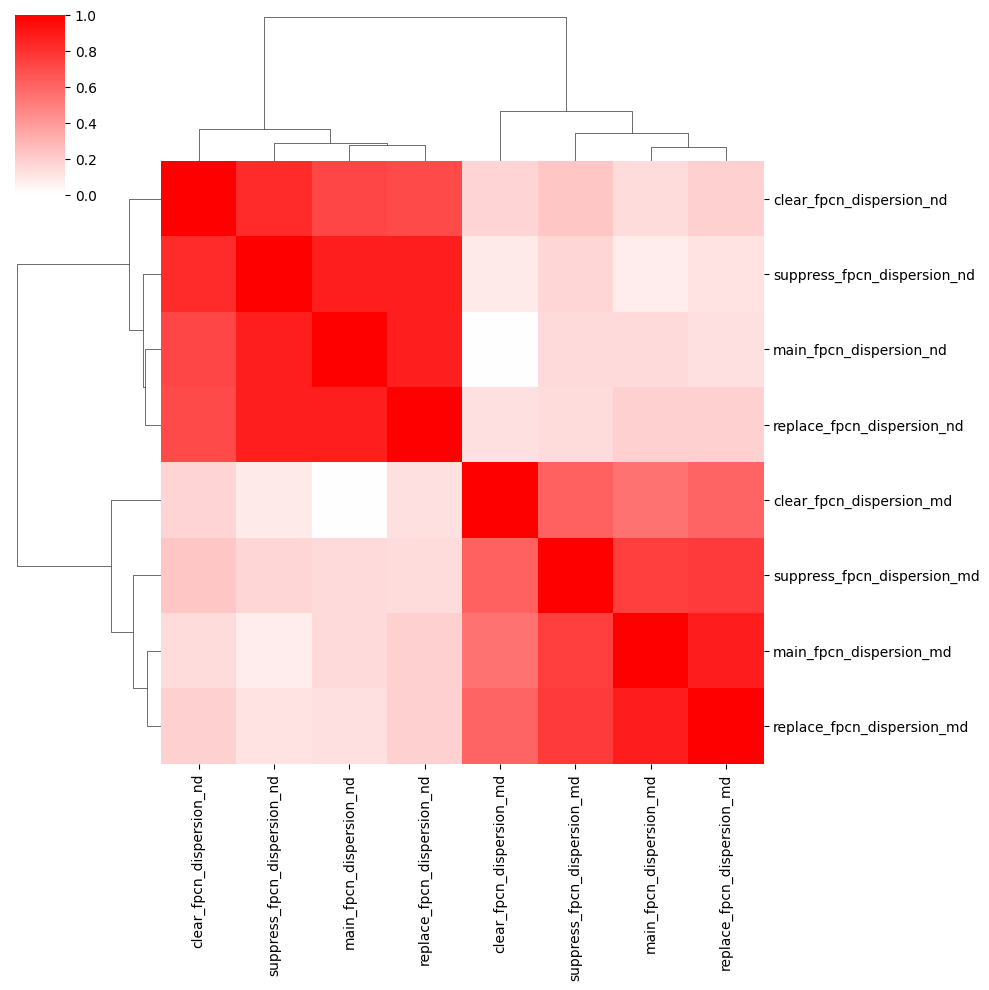

In [66]:
sns.clustermap(all_sub_data_with_rrs.filter(regex='fpcn_dispersion_nd|fpcn_dispersion_md').corr(), cmap='bwr', center=0)

In [67]:
all_sub_data_with_rrs.shape

(48, 10152)

In [68]:
wm_stroop_stern = pd.read_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/WM_stroop_stern.csv')
all_sub_data_with_stroop_stern = pd.merge(all_sub_data_with_rrs, wm_stroop_stern, on ='SubID').dropna()

stroop_stern_cols = ['100_intr_costs_stern', '2000_intr_costs_stern','inc25_cong_ACC_stroop', 'inc25_inc_ACC_stroop', 
'inc75_cong_ACC_stroop', 'inc75_inc_ACC_stroop','inc25_stroop_eff_stroop', 'inc75_stroop_eff_stroop']

In [69]:
operation_disp_cols = ['main_vn_dispersion_md', 'main_smn_dispersion_md',
       'main_fpcn_dispersion_md', 'main_dmn_dispersion_md',
       'replace_vn_dispersion_md', 'replace_smn_dispersion_md',
       'replace_fpcn_dispersion_md', 'replace_dmn_dispersion_md',
       'suppress_vn_dispersion_md', 'suppress_smn_dispersion_md',
       'suppress_fpcn_dispersion_md', 'suppress_dmn_dispersion_md',
       'clear_vn_dispersion_md', 'clear_smn_dispersion_md',
       'clear_fpcn_dispersion_md', 'clear_dmn_dispersion_md']

pull_cols = ['SubID'] + operation_disp_cols# + stroop_stern_cols + measures 

In [70]:
pull_data_dispersion = pd.merge(all_sub_data_with_rrs, wm_stroop_stern, on='SubID')

In [71]:
pull_data_dispersion = pull_data_dispersion[pull_cols]

pull_data_dispersion.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_within_network_dispersion.csv',index=False)

In [52]:
pull_data_dispersion

,SubID,main_vn_dispersion_md,main_smn_dispersion_md,main_fpcn_dispersion_md,main_dmn_dispersion_md,replace_vn_dispersion_md,replace_smn_dispersion_md,replace_fpcn_dispersion_md,replace_dmn_dispersion_md,suppress_vn_dispersion_md,suppress_smn_dispersion_md,suppress_fpcn_dispersion_md,suppress_dmn_dispersion_md,clear_vn_dispersion_md,clear_smn_dispersion_md,clear_fpcn_dispersion_md,clear_dmn_dispersion_md
0,1,143.313220,100.708047,147.192242,136.536015,137.660149,99.668834,144.998563,132.492432,142.491011,100.890915,145.463102,128.025370,139.060434,96.412910,139.511307,131.897360
1,4,148.586971,95.692376,144.799448,149.899124,150.297047,96.633732,140.851280,149.262222,147.277354,93.934106,143.925131,147.914273,140.762980,91.492325,145.559176,150.390650
2,5,136.697125,101.889159,139.165218,139.088132,137.073917,101.983382,142.755313,141.198467,135.248691,102.228314,141.225793,137.475002,142.367489,104.094554,149.079019,138.450994
3,6,149.863887,94.538093,149.016680,148.190275,149.457753,96.172736,149.749336,146.474797,149.965808,97.001516,145.438701,149.958052,144.321637,91.900779,150.690369,154.739430
4,8,147.220121,99.070298,155.505873,151.985080,148.342009,98.749660,152.238207,150.462097,148.484612,99.227168,151.191657,147.874609,139.137539,95.280198,150.055159,147.128844
5,11,142.484913,99.086596,160.892679,156.222005,150.232991,99.325150,158.741196,151.560240,150.493832,97.923449,153.555574,140.600785,140.097504,94.727497,146.733389,158.471451
6,12,153.025067,97.761746,149.547046,156.744777,145.832791,98.061077,151.559166,158.470169,150.814861,99.778725,152.498694,151.201136,151.464136,100.983437,157.220799,159.495097
7,13,144.587051,103.304010,157.806204,154.239475,140.320667,96.911723,155.309960,153.018455,140.459738,100.440431,155.237533,149.349552,136.055099,96.003538,158.112882,147.100955
8,15,137.136718,98.244401,152.493321,138.240846,137.835672,98.486091,150.893743,145.514795,137.154936,98.979874,148.332759,144.535273,130.768530,98.505801,148.331804,139.243478
9,17,136.794451,100.312894,154.700731,146.532552,141.449092,96.911563,155.522582,152.589218,154.786462,98.831291,154.550523,153.352668,140.340369,93.913619,146.791978,149.392496


In [53]:
all_sub_data_with_rrs.shape

(48, 10152)

In [54]:
#all_sub_data_with_rrs

In [95]:
wm_dispersion_data = (all_sub_data_with_rrs
 .filter(regex='SubID|fpcn|dmn|vn|smn')
 #.filter(like='dispersion_md')
 .filter(regex='SubID|dispersion_md')
 #.filter(regex='^(?!.*(clear|suppress|replace)).*$')
)

#wm_dispersion_data.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/derosa_task_network_dispersion.csv', index=False)

In [96]:
def pls(data, target, networks, color, save=None):


    regex_string = '|'.join(networks)

    import seaborn as sns
    from sklearn.cross_decomposition import PLSRegression
    from scipy.stats import t
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm

    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import StandardScaler
    
    from sklearn.model_selection import cross_val_predict
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import LeaveOneOut
    # Create an instance of LeaveOneOut
    loo = LeaveOneOut()

    
    scaler=MinMaxScaler()
    
    X_data = data
    # Extract the feature matrix X and target variable y
    X = (X_data 
             .filter(regex=regex_string)
             .filter(like='dispersion_md')
             #.filter(regex='^(?!.*(main|suppress|replace)).*$')
             #.filter(regex='^(?!.*(maintain_smn)).*$') 
            )

    # fit and transform the entire dataframe
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    y = X_data[target]
    y = pd.DataFrame(scaler.fit_transform(y), columns=y.columns)

    # Set the number of permutations and bootstrap repetitions
    n_permutations = 10000
    n_bootstrap = 10000

    pls = PLSRegression(n_components=1)
        
    # Perform leave-one-out cross-validation to determine the optimal number of components
    mse_values = []
    for n_components in range(1, len(X.columns)+1):
        pls.n_components = n_components
        y_pred = cross_val_predict(pls, X, y, cv=loo)
        mse = mean_squared_error(y, y_pred)
        mse_values.append(mse)

    #pls = PLSRegression(n_components=1)
    optimal_n_components = np.argmin(mse_values) + 1
    print('Optimal number of components:', optimal_n_components)

    # Fit the PLSRegression model to the feature matrix X and target variable y using the optimal number of components
    pls.n_components = 1 #optimal_n_components
    pls.fit(X, y)

    # Compute the singular value of the fitted model
    x_score = pls.x_scores_
    y_score = pls.y_scores_
    singular_value = np.dot(x_score.T, y_score)

    # Generate permuted data matrices by randomly reordering the rows of the original data matrix X
    permuted_singular_values = []
    for i in range(n_permutations):
        permuted_X = X.sample(frac=1, replace=False)
        pls.fit(permuted_X, y)
        x_score = pls.x_scores_
        y_score = pls.y_scores_
        permuted_singular_value = np.dot(x_score.T, y_score)
        permuted_singular_values.append(permuted_singular_value)

    # Compute the p-value of the singular value by comparing it to the null distribution of singular values
    p_value = (np.sum(permuted_singular_values >= singular_value) + 1) / (n_permutations + 1)
    
    import seaborn as sns
    from sklearn.cross_decomposition import PLSRegression
    from scipy.stats import t
    import numpy as np
    import matplotlib.pyplot as plt
    import statsmodels.api as sm
    import matplotlib

       # Prepare data for the histogram
    singular_list = [i[0][0] for i in permuted_singular_values]
    singulars = pd.DataFrame(singular_list, columns=['Singulars'])
    singular_val = singular_value[0][0]

    # Begin plotting
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))  # Set up a figure with two subplots
    
    # Scatter plot on the left
    sns.set_theme(style="white")

    sns.regplot(x=x_score.flatten(), y=y_score.flatten(), 
                ax=axs[0], color=color, scatter_kws={'alpha':0.6}, truncate=False)
    axs[0].set_xlabel('Network Dispersion (Latent Variable)', fontsize=14)
    axs[0].set_ylabel('Behavior (Latent Variable)', fontsize=14)
    axs[0].set_title('Network Dispersion Predicting Behavior', fontsize=14, fontweight='bold')
    
       # Displaying 'permuted P = ' with manual positioning for readability
    axs[0].text(.06, 1, 'permuted ', transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black')
    axs[0].text(.22, 1, 'P', transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black', fontstyle='italic')
    axs[0].text(.24, 1, ' = {:.3f}'.format(p_value), transform=axs[0].transAxes, fontsize=13, verticalalignment='top', color='black')
    
    sns.despine(ax=axs[0])

    # Histogram on the right
    sns.histplot(singulars, kde=False, ax=axs[1])
    axs[1].axvline(x=singular_val, color='r', linestyle='--', label='Singular Value')
    axs[1].legend()
    axs[1].set_title("Singular Value vs. Null Distribution", fontsize=14, fontweight='bold')
    axs[1].set_xlabel('Permuted Singular Values (Null)', fontsize=14)
    sns.despine(ax=axs[1])
    plt.tight_layout()  # Adjust layout to not overlap
    
    if save is not None:
        save_path = f"/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/pls_plots/derosa_{save}.png"
        plt.savefig(save_path, dpi=700)
        
    plt.tight_layout()  # Adjust layout to not overlap
    plt.show()
    

    return p_value, x_score, y_score, permuted_singular_values, singular_value


In [97]:
#all_sub_data_with_rrs.to_csv('/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/dispersion_data/rsa_all_sub_data_with_rrs.csv')

In [98]:
all_sub_data_with_rrs.filter(regex='dispersion_md')

,main_vn_dispersion_md,main_smn_dispersion_md,main_fpcn_dispersion_md,main_dmn_dispersion_md,replace_vn_dispersion_md,replace_smn_dispersion_md,replace_fpcn_dispersion_md,replace_dmn_dispersion_md,suppress_vn_dispersion_md,suppress_smn_dispersion_md,suppress_fpcn_dispersion_md,suppress_dmn_dispersion_md,clear_vn_dispersion_md,clear_smn_dispersion_md,clear_fpcn_dispersion_md,clear_dmn_dispersion_md
0,143.313220,100.708047,147.192242,136.536015,137.660149,99.668834,144.998563,132.492432,142.491011,100.890915,145.463102,128.025370,139.060434,96.412910,139.511307,131.897360
1,148.586971,95.692376,144.799448,149.899124,150.297047,96.633732,140.851280,149.262222,147.277354,93.934106,143.925131,147.914273,140.762980,91.492325,145.559176,150.390650
2,136.697125,101.889159,139.165218,139.088132,137.073917,101.983382,142.755313,141.198467,135.248691,102.228314,141.225793,137.475002,142.367489,104.094554,149.079019,138.450994
3,149.863887,94.538093,149.016680,148.190275,149.457753,96.172736,149.749336,146.474797,149.965808,97.001516,145.438701,149.958052,144.321637,91.900779,150.690369,154.739430
4,147.220121,99.070298,155.505873,151.985080,148.342009,98.749660,152.238207,150.462097,148.484612,99.227168,151.191657,147.874609,139.137539,95.280198,150.055159,147.128844
5,142.484913,99.086596,160.892679,156.222005,150.232991,99.325150,158.741196,151.560240,150.493832,97.923449,153.555574,140.600785,140.097504,94.727497,146.733389,158.471451
6,153.025067,97.761746,149.547046,156.744777,145.832791,98.061077,151.559166,158.470169,150.814861,99.778725,152.498694,151.201136,151.464136,100.983437,157.220799,159.495097
7,144.587051,103.304010,157.806204,154.239475,140.320667,96.911723,155.309960,153.018455,140.459738,100.440431,155.237533,149.349552,136.055099,96.003538,158.112882,147.100955
8,137.136718,98.244401,152.493321,138.240846,137.835672,98.486091,150.893743,145.514795,137.154936,98.979874,148.332759,144.535273,130.768530,98.505801,148.331804,139.243478
9,136.794451,100.312894,154.700731,146.532552,141.449092,96.911563,155.522582,152.589218,154.786462,98.831291,154.550523,153.352668,140.340369,93.913619,146.791978,149.392496


Optimal number of components: 1


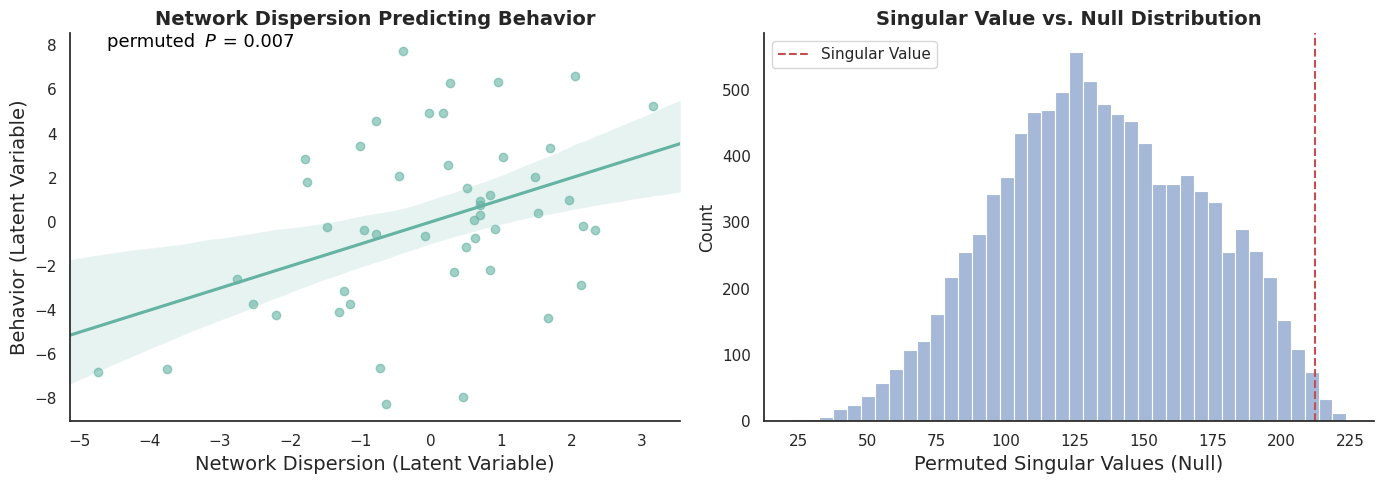

Optimal number of components: 1


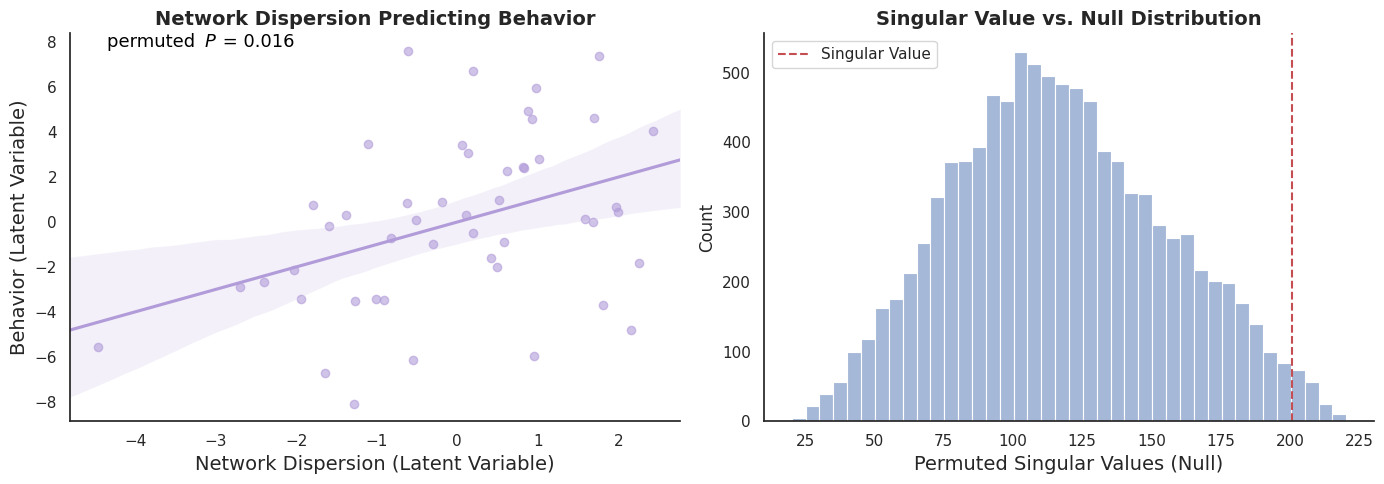

Optimal number of components: 1


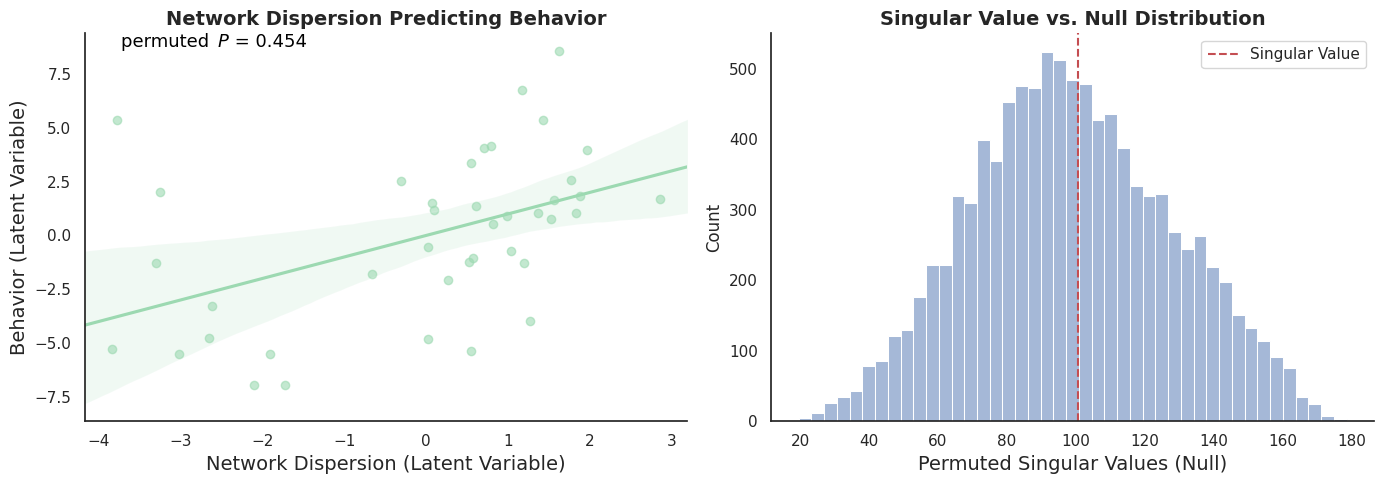

Optimal number of components: 1


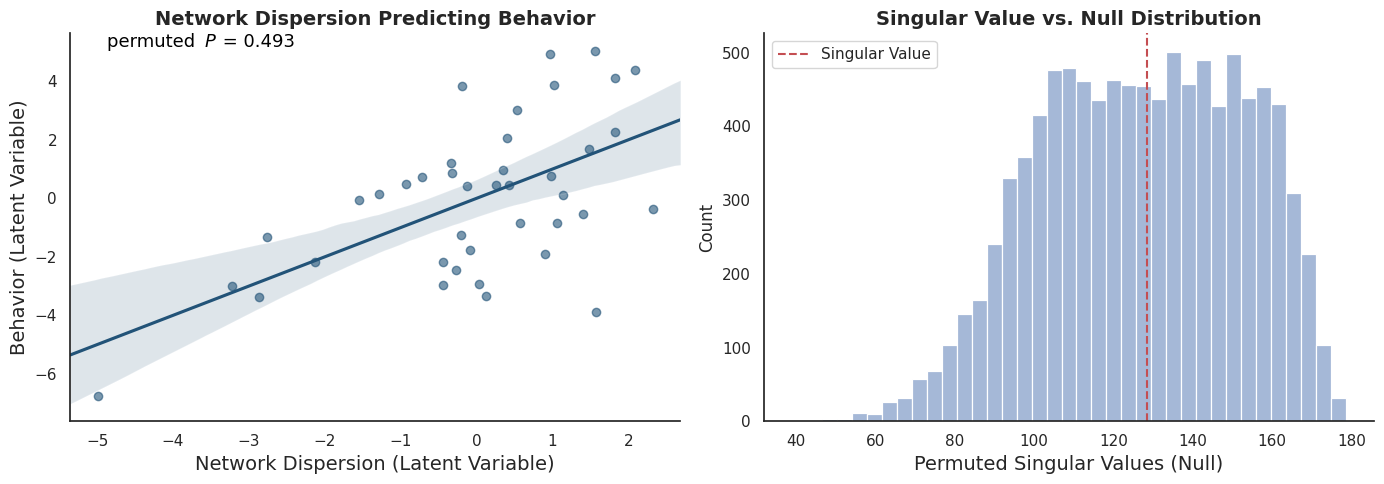

In [100]:
networks = ['vn', 'smn', 'fpcn', 'dmn']

targets = [['RRS_total', 'PSWQ_total', 'WBSI_total'], ['z_ave']]
colors = ['#64b3a3', '#b19cd9']
names = ['rrs_pws_wbsi', 'z_ave', ]
for i,j,k in zip(targets, colors, names):
    p_value, x_score, y_score, permuted_singular_values, singular_value = pls(all_sub_data_with_rrs, i, networks, j, k)
    
targets = [['inc25_stroop_eff_stroop', 'inc75_stroop_eff_stroop'],
           ['100_intr_costs_stern', '2000_intr_costs_stern','inc25_cong_ACC_stroop', 'inc25_inc_ACC_stroop', 'inc75_cong_ACC_stroop',
            'inc75_inc_ACC_stroop','inc25_stroop_eff_stroop', 'inc75_stroop_eff_stroop']]
colors = ['#9cd9b1', '#225378']
names = ['stroop_eff', 'stroop_acc_stern_int']
for i,j,k in zip(targets, colors, names):
    p_value, x_score, y_score, permuted_singular_values, singular_value = pls(all_sub_data_with_stroop_stern, i, networks, j, k)

In [ ]:
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
# initialize the scaler object
scaler=MinMaxScaler()

X_data = all_sub_data_with_stroop_stern

# Extract the feature matrix X and target variable y
X = (X_data 
         .filter(regex='fpcn|dmn|vn|smn')
         .filter(like='dispersion_md')
         #.filter(regex='^(?!.*(main|suppress|replace)).*$')
         #.filter(regex='^(?!.*(maintain_smn)).*$') 
        )

# fit and transform the entire dataframe
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

#target = ['RRS_total', 'PSWQ_total', 'WBSI_total']
#target = ['z_ave']
target = ['inc25_stroop_eff_stroop', 'inc75_stroop_eff_stroop']

stroop_stern_cols = ['100_intr_costs_stern', '2000_intr_costs_stern','inc25_cong_ACC_stroop', 'inc25_inc_ACC_stroop', 
'inc75_cong_ACC_stroop', 'inc75_inc_ACC_stroop','inc25_stroop_eff_stroop', 'inc75_stroop_eff_stroop']

y = X_data[target]
y = pd.DataFrame(scaler.fit_transform(y), columns=y.columns)

In [42]:
X

,main_vn_dispersion_md,main_smn_dispersion_md,main_fpcn_dispersion_md,main_dmn_dispersion_md,replace_vn_dispersion_md,replace_smn_dispersion_md,replace_fpcn_dispersion_md,replace_dmn_dispersion_md,suppress_vn_dispersion_md,suppress_smn_dispersion_md,suppress_fpcn_dispersion_md,suppress_dmn_dispersion_md,clear_vn_dispersion_md,clear_smn_dispersion_md,clear_fpcn_dispersion_md,clear_dmn_dispersion_md
0,0.369089,0.159940,0.576796,0.629803,0.576750,0.201444,0.558040,1.000000,0.600010,0.120129,0.532245,1.000000,0.641722,0.615016,0.954977,0.996728
1,0.206773,0.415599,0.672373,0.263564,0.148414,0.408230,0.726446,0.381689,0.366439,0.657233,0.599050,0.380156,0.568158,0.989987,0.644488,0.393884
2,0.572719,0.099736,0.897425,0.559858,0.596621,0.043751,0.649130,0.679004,0.953430,0.016874,0.716301,0.705499,0.498830,0.029639,0.463785,0.783093
3,0.167472,0.474435,0.503921,0.310398,0.176863,0.439638,0.365128,0.484463,0.235245,0.420412,0.533305,0.316461,0.414395,0.958861,0.381060,0.252123
4,0.248842,0.243419,0.244719,0.206395,0.214681,0.264069,0.264063,0.337449,0.307526,0.248579,0.283412,0.381392,0.638390,0.701334,0.413671,0.500213
5,0.394582,0.242589,0.029550,0.090275,0.150585,0.224860,0.000000,0.296960,0.209477,0.349233,0.180731,0.608083,0.596912,0.743452,0.584206,0.130466
6,0.329883,0.027618,0.152835,0.144610,0.486570,0.389290,0.139330,0.243195,0.699134,0.154909,0.107671,0.335425,0.771577,0.646212,0.000000,0.501122
7,0.559189,0.285517,0.365051,0.583079,0.570801,0.282026,0.318657,0.519859,0.860406,0.267672,0.407595,0.485463,1.000000,0.455528,0.502146,0.757260
8,0.569724,0.180082,0.276879,0.355831,0.448322,0.389301,0.130697,0.259021,0.000000,0.279143,0.137513,0.210666,0.586418,0.805474,0.581198,0.426422
9,0.627325,0.126721,0.590233,0.531626,0.493676,0.000000,0.492729,0.929438,0.938168,0.053258,0.486857,0.813659,0.624152,0.249791,0.509384,0.898570


In [43]:
# Set the number of permutations and bootstrap repetitions
n_permutations = 10000
n_bootstrap = 10000

# Perform leave-one-out cross-validation to determine the optimal number of components
#mse_values = []
#for n_components in range(1, len(X.columns)+1):
#    pls.n_components = n_components
#    y_pred = cross_val_predict(pls, X, y, cv=loo)
#    mse = mean_squared_error(y, y_pred)
#    mse_values.append(mse)
    
pls = PLSRegression(n_components=1)
#optimal_n_components = np.argmin(mse_values) + 1
#print('Optimal number of components:', optimal_n_components)

# Fit the PLSRegression model to the feature matrix X and target variable y using the optimal number of components
pls.n_components = 1 #optimal_n_components
pls.fit(X, y)

# Compute the singular value of the fitted model
x_score = pls.x_scores_
y_score = pls.y_scores_
singular_value = np.dot(x_score.T, y_score)

# Generate permuted data matrices by randomly reordering the rows of the original data matrix X
permuted_singular_values = []
for i in range(n_permutations):
    permuted_X = X.sample(frac=1, replace=False)
    pls.fit(permuted_X, y)
    x_score = pls.x_scores_
    y_score = pls.y_scores_
    permuted_singular_value = np.dot(x_score.T, y_score)
    permuted_singular_values.append(permuted_singular_value)

# Compute the p-value of the singular value by comparing it to the null distribution of singular values
p_value = (np.sum(permuted_singular_values >= singular_value) + 1) / (n_permutations + 1)
p_value

0.45285471452854714

In [44]:
#p_value = .006
#p_value = .014

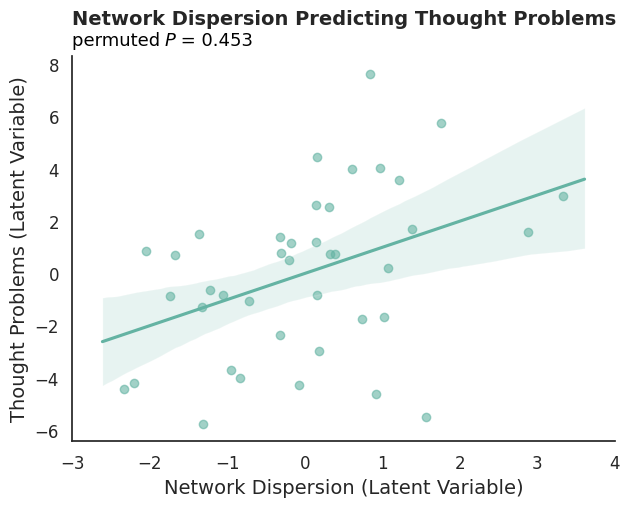

In [45]:
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import t
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib

# set Arial as the default font for all text elements in the plot
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Arial']

fig = plt.figure(figsize=(7, 5))
sns.set_theme(style="white")
    
color = '#64b3a3'
#color = '#b19cd9'
# Extract the scores for X and Y
x_scores, y_scores = pls.x_scores_, pls.y_scores_

# Create a scatter plot of the X and Y component scores with a regression line
g = sns.regplot(x=x_scores.flatten(),
                y=y_scores.flatten(), 
                color=color, 
                scatter_kws={'alpha':0.6},
                 truncate=False
               )

# Fit a linear regression model to the data
#X_with_intercept = sm.add_constant(x_scores)
#model = sm.OLS(y_scores, X_with_intercept)
#results = model.fit()

# Calculate confidence intervals for the regression coefficients
#conf_ints = results.conf_int(alpha=0.05)[1]
# Calculate the regression line
#slope, intercept = np.polyfit(x_scores.flatten(), y_scores.flatten(), 1)
#reg_line_x = np.linspace(x_scores.min(), x_scores.max(), 100)
#reg_line_y = slope * reg_line_x + intercept 

# Add labels, legend, and R2 value
plt.xlabel('Network Dispersion (Latent Variable)', fontsize=14)
plt.ylabel('Thought Problems (Latent Variable)', fontsize=14)

plt.title('Network Dispersion Predicting Thought Problems', 
          fontsize=14, loc='left', pad=23,
          fontweight='bold')

plt.text(0, 1.065, 'permuted ', 
         transform=plt.gca().transAxes, fontsize=13,
         verticalalignment='top', color='black')

plt.text(0.17, 1.065, 'P', 
         transform=plt.gca().transAxes, fontsize=13,
         verticalalignment='top', color='black',
         fontstyle='italic')


plt.text(0.19, 1.065, f' = {p_value:.3f}', 
         transform=plt.gca().transAxes, fontsize=13,
         verticalalignment='top', color='black')

# Remove top and right spines
sns.despine()
# Set the x and y axis limits to the max and min scores
#x_max, x_min = round(np.max(x_scores)), round(np.min(x_scores))
#y_max, y_min = round(np.max(y_scores)), round(np.min(y_scores))

plt.xlim(-3, 4)
#plt.ylim(-8,7)

# Calculate the best distance between x and y axis ticks
#x_ticks = plt.xticks()[0].astype(int)
y_ticks = plt.yticks()[0].astype(int)

#num_ticks = max(len(x_ticks), len(y_ticks)) - 1
#best_distance = max(abs(x_max - x_min), abs(y_max - y_min)) / (num_ticks - 1)

# Set the x and y axis ticks to go all the way to the end of the plot and have best distance
#x_ticks_new = np.linspace(round(x_min), round(x_max), num_ticks).astype(int)
#y_ticks_new = np.linspace(round(y_min), round(y_max)).astype(int)
# Set the font size of the tick labels
#x_ticks = list(range(-3, 7, 2))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Set the width of the tick marks and labels
g.tick_params(axis='both', which='both', width=2)
#plt.gcf().savefig("/pl/active/banich/studies/wmem/fmri/operation_rsa/grp/gradients/analysis/thought_problems_plot.png", dpi=700)

In [46]:
#pd.DataFrame(x_scores, columns=['dispersion']).sort_values(['dispersion'])

# High = SubID 1 = sub 1
# Low = SubID 20 = sub 12 

id_no_19.query('SubID == 1 or SubID == 20')

,index,SubID,sub
0,0,1,1
11,11,20,12


In [47]:
# Bootstrap resampling to estimate standard error of weights
bootstrap_ratios = []
for i in range(n_bootstrap):
    idx = np.random.choice(range(len(X)), size=len(X), replace=True)
    pls.fit(X.iloc[idx,:], y.iloc[idx])
    bootstrap_ratios.append(pls.coef_ / np.std(pls.coef_))

bootstrap_ratios = np.vstack(bootstrap_ratios)
bootstrap_standard_errors = np.std(bootstrap_ratios, axis=0)

# Compute the bootstrap ratio of each variable's weight to its bootstrap-estimated standard error
bootstrap_weight_ratios = pls.coef_ / bootstrap_standard_errors

# Print the p-value and bootstrap weight ratios
print('p-value: ', p_value)
print('Bootstrap weight ratios:')
for i in range(len(bootstrap_weight_ratios)):
    print('Variable', i, ':', bootstrap_weight_ratios[i][0])

# Load data and define target variable
X = (all_sub_data_with_rrs
         .filter(regex='fpcn|dmn|vn|smn')
         .filter(like='dispersion_md')
        # .filter(regex='^(?!.*(replace_dmn|maintain_dmn)).*$') 
         #.filter(regex='^(?!.*(maintain_smn|replace_smn|suppress_smn)).*$') 
        )
    
boot_out = pd.DataFrame(bootstrap_weight_ratios).assign(network = X.columns.to_list())[[0, 'network']]
boot_out.columns = ['loading', 'network']

boot_out.sort_values('loading', ascending=False)

p-value:  0.45285471452854714
Bootstrap weight ratios:
Variable 0 : -0.000738732717768535
Variable 1 : 0.005005572531334216
Variable 2 : 0.0030883779743080255
Variable 3 : 0.0012158390366319336
Variable 4 : -0.00039957895476788437
Variable 5 : 0.0036889882124767296
Variable 6 : 0.004243637563815704
Variable 7 : 0.0024433843363945904
Variable 8 : -0.0019419487265347646
Variable 9 : 0.0032483566429002
Variable 10 : 0.004541966928751606
Variable 11 : 0.003456934305682359
Variable 12 : -0.007056014391296614
Variable 13 : 0.0029557213436546895
Variable 14 : 0.003102501882605236
Variable 15 : 0.0051966761795295335


,loading,network
15,0.005197,clear_dmn_dispersion_md
1,0.005006,main_smn_dispersion_md
10,0.004542,suppress_fpcn_dispersion_md
6,0.004244,replace_fpcn_dispersion_md
5,0.003689,replace_smn_dispersion_md
11,0.003457,suppress_dmn_dispersion_md
9,0.003248,suppress_smn_dispersion_md
14,0.003103,clear_fpcn_dispersion_md
2,0.003088,main_fpcn_dispersion_md
13,0.002956,clear_smn_dispersion_md


In [ ]:
#!jupyter nbconvert --to script z_ave_predictions.ipynb